This model is based off of [this SAM Model example](https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb)

Packages

In [1]:
from datasets import load_dataset
from PIL import Image
import os
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from transformers import SamProcessor, SamModel, SamConfig
import torch
from patchify import patchify
from torchvision import transforms
from torch.optim import AdamW
from statistics import mean
from tqdm.auto import tqdm
from torchmetrics import JaccardIndex, Accuracy
from datasets import Dataset

/home/sking11/.conda/envs/dino_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


# Loading in Data

In [2]:
from datasets import load_dataset

dataset = load_dataset('saking3/alaska_dead_trees')

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6400
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 653
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1286
    })
})

Dataset labels

In [4]:
#get labels for each dataset 
id2label = {0: 'Background', 1: 'Dead Tree'}

Create a 'dataset' that serves us input images and masks

In [17]:
from datasets import Dataset, DatasetDict

def create_dataset(data_dict):
    # Extract images and labels directly from the provided dictionary
    images = data_dict['image']
    labels = data_dict['label']

    # Create a new dataset from the images and labels
    dataset_dict = {
        "image": images,
        "label": labels
    }

    # Create and return the Dataset object
    dataset = Dataset.from_dict(dataset_dict)
    return dataset

# Assuming you already have your data loaded from Hugging Face as `dataset`
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

# Create the datasets using the adjusted function
train_dataset = create_dataset({"image": train_data["image"], "label": train_data["label"]})
val_dataset = create_dataset({"image": val_data["image"], "label": val_data["label"]})
test_dataset = create_dataset({"image": test_data["image"], "label": test_data["label"]})

In [18]:
print("Number of train images:", len(train_dataset))
print("Number of val images:", len(val_dataset))
print("Number of test images:", len(test_dataset))

Number of train images: 6400
Number of val images: 653
Number of test images: 1286


Data can be randomly subset to reduce training size in a similar manner as follows:

```
random_indices = np.random.choice(len(dataset["train"]), size=training_size, replace=False)
train_subset = dataset["train"].select(random_indices)

# Create a new DatasetDict with the subset
subset_training_dataset = DatasetDict({
    "train": train_subset,
    "validation": dataset["validation"],
    "test": dataset["test"]
})
```

Let's make sure that images and masks (labels) are loading appropriately by loading one of each

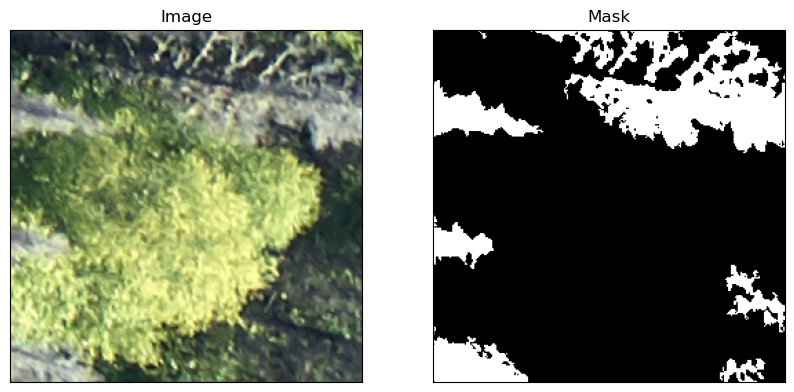

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Pull a random sample from the train_dataset
img_num = random.randint(0, len(train_dataset) - 1)  # Adjust to len(train_dataset) - 1 to avoid out-of-bounds error
example = train_dataset[img_num]

# Extract the image and mask from the sample
example_image = example["image"]  # PIL image
example_mask = np.array(example["label"])  # Convert mask to NumPy array if it's not already

# If the image is a PIL image, convert it to NumPy array for plotting
example_image_np = np.array(example_image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image on the left
axes[0].imshow(example_image_np)  # Display the image
axes[0].set_title("Image")

# Plot the mask on the right
axes[1].imshow(example_mask, cmap='gray')  # Display the mask
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks.

In [20]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

Create a 'dataset' that serves us input images and masks in a format appropriate for the SAM model.

In [21]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [22]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [23]:
# Create an instance of the SAMDataset
sam_train_dataset = SAMDataset(dataset=test_dataset, processor=processor)
sam_val_dataset = SAMDataset(dataset=val_dataset, processor=processor)
sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor)

In [24]:
print("Number of train images:", len(sam_train_dataset))
print("Number of val images:", len(sam_val_dataset))
print("Number of test images:", len(sam_test_dataset))

Number of train images: 1286
Number of val images: 653
Number of test images: 1286


Take a look at one example from the sam_train_dataset to verify dimensions. 

In [25]:
example = sam_train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


Making dataloaders that will feed data to the model.

In [26]:
train_dataloader = DataLoader(sam_train_dataset, batch_size=4, shuffle=True, drop_last=False)
val_dataloader = DataLoader(sam_val_dataset, batch_size=4, shuffle=False, drop_last=False)
test_dataloader = DataLoader(sam_test_dataset, batch_size=4, shuffle=False, drop_last=False)

Take a look at one example from the train_dataloader to verify dimensions. 

In [27]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
input_boxes torch.Size([4, 1, 4])
ground_truth_mask torch.Size([4, 256, 256])


# Training the Model

Initializing the model

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Depending on the number of cuda devices available to you, which can be checked via: `print(torch.cuda.device_count())`

You can parallelize the model across multiple devices by setting the initial device to:
`device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")` 

Then setting the model to run in parallel across multiple devices with nn.DataParallel()
```
import torch.nn as nn
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model.to(device)
```

In [1]:
from transformers import SamProcessor, SamModel, SamConfig
from monai.losses import DiceCELoss
from torch.optim import Adam

# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

/home/sking11/.conda/envs/dino_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# Load the SAM model
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(True)

In [31]:
torch.cuda.is_available()
print(f"Using device: {device}")

Using device: cuda


In [32]:
# Initialize the optimizer and the loss function
learning_rate = 1e-6
optimizer = Adam(model.mask_decoder.parameters(), lr=learning_rate, weight_decay=0)
seg_loss = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Training loop
num_epochs = 10
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [85]:
#training the model
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].to(device)

        # Ensure ground truth masks have shape [batch_size, 1, height, width]
        if ground_truth_masks.dim() == 3:
            ground_truth_masks = ground_truth_masks.unsqueeze(1)

        loss = seg_loss(predicted_masks, ground_truth_masks)

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        
    # Compute and print metrics for the epoch
    mean_iou = iou_metric.compute().mean().item()
    mean_accuracy = accuracy_metric.compute().item()
    
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {sum(epoch_losses) / len(epoch_losses)}')
    print(f'Mean IoU: {mean_iou}')
    print(f'Mean accuracy: {mean_accuracy}')

100%|██████████| 322/322 [20:25<00:00,  3.81s/it]
/home/sking11/.conda/envs/dino_env/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric BinaryJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/sking11/.conda/envs/dino_env/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric BinaryAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


EPOCH: 0
Mean loss: -21587.590876040253
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:25<00:00,  3.81s/it]


EPOCH: 1
Mean loss: -42733.999125794595
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:21<00:00,  3.79s/it]


EPOCH: 2
Mean loss: -61710.88721840426
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:21<00:00,  3.79s/it]


EPOCH: 3
Mean loss: -79605.22441224282
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:09<00:00,  3.76s/it]


EPOCH: 4
Mean loss: -96870.8062069342
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:09<00:00,  3.76s/it]


EPOCH: 5
Mean loss: -114058.55333486995
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:40<00:00,  3.85s/it]


EPOCH: 6
Mean loss: -130459.26372949826
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:16<00:00,  3.78s/it]


EPOCH: 7
Mean loss: -146229.7846164111
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:24<00:00,  3.80s/it]


EPOCH: 8
Mean loss: -162192.720487796
Mean IoU: nan
Mean accuracy: 0.0


100%|██████████| 322/322 [20:22<00:00,  3.80s/it]

EPOCH: 9
Mean loss: -178353.05576414499
Mean IoU: nan
Mean accuracy: 0.0


In [86]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), '/explore/nobackup/people/sking11/sam_model_checkpoint.pth')
torch.save(model, '/explore/nobackup/people/sking11/sammodel.pth')

# Performing Inference on single tile for dataset

In [33]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load('/explore/nobackup/people/sking11/sam_model_checkpoint_6400.pth'))

/tmp/ipykernel_2426568/3551041950.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_mito_model.load_state_dict(torch.load('/explore/nobackup/people/sking11/sam_model_ch

<All keys matched successfully>

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

We will now select a random example from our dataset, and run predictions on it using our predictive my_mito_model. Then, we will plot the original image, the probability map predicted by SAM, and the final mask.  

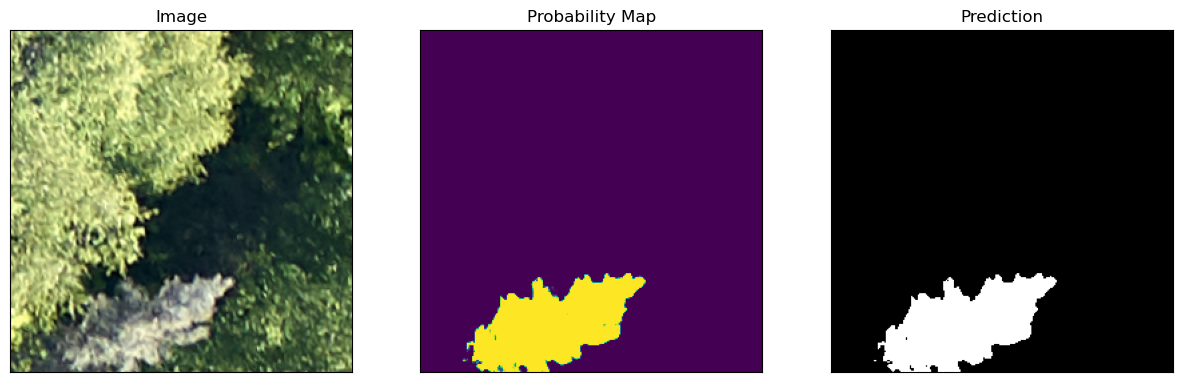

In [35]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

img_num = random.randint(0, len(val_dataset))

# load image
test_image = val_dataset[img_num]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(val_dataset[img_num]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image))  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Running Model Statistics using our evaluation dataset

In order to run model statistics, we need to first get predictions for a validation/test dataset of images. The following block will run model predictions on an entire set of images and save them to a numpy list and as PIL images in an output folder of your choosing.

In [36]:
import torch
import os
from PIL import Image
import numpy as np
from tqdm import tqdm  # Optional, for displaying a progress bar

# Ensure the output directory exists
output_dir = "/explore/nobackup/people/sking11/SAM_output_masks"
os.makedirs(output_dir, exist_ok=True)

def generate_predicted_masks(val_dataset, model, processor, device):
    predicted_masks = []

    model.eval()
    for idx in tqdm(range(len(val_dataset))):
        # Extract image and label from the dataset
        item = val_dataset[idx]
        val_image = item['image']
        label = item['label']

        # Prepare the image for the model using the processor
        inputs = processor(val_image, return_tensors="pt")

        # Move inputs to the appropriate device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, multimask_output=False)

        # Apply sigmoid to get the probability map
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

        # Convert soft mask to hard mask and move to CPU
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        # Append the predicted mask (as a NumPy array) to the list
        predicted_masks.append(medsam_seg)

        # Save the predicted mask as a PNG file
        #file_path = os.path.join(output_dir, f"predicted_mask_{idx}.png")
        #Image.fromarray(medsam_seg * 255).save(file_path)  # Scale to 0-255 for visualization

    print(f"Total Predicted Masks: {len(predicted_masks)}")
    return predicted_masks

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
val_predicted_masks = generate_predicted_masks(val_dataset, my_mito_model, processor, device)

100%|██████████| 653/653 [01:59<00:00,  5.47it/s]

Total Predicted Masks: 653


In [41]:
def get_numpy_masks(val_dataset):
    numpy_masks = []
    for idx in range(len(val_dataset)):
        mask = val_dataset[idx]['label']
        numpy_masks.append(np.array(mask))
    return numpy_masks

val_original_masks = get_numpy_masks(val_dataset)

In [42]:
print(len(val_predicted_masks))
print(len(val_original_masks))

653
653


In [43]:
# Ensure both lists have the same length
assert len(val_original_masks) == len(val_predicted_masks), "Mismatch in number of masks"

# Calculate accuracy for each tile
accuracies = []
for actual_mask, predicted_mask in zip(val_original_masks, val_predicted_masks):
    # Ensure both masks have the same shape
    assert actual_mask.shape == predicted_mask.shape, "Mismatch in mask shapes"
    
    # Calculate the number of correctly predicted pixels
    correct_pixels = np.sum(actual_mask == predicted_mask)
    total_pixels = actual_mask.size
    accuracy = correct_pixels / total_pixels
    
    accuracies.append(accuracy)

# Now, accuracies contains the accuracy for each tile
for idx, acc in enumerate(accuracies):
    print(f"Tile {idx}: Accuracy = {acc:.4f}")

Tile 0: Accuracy = 0.6502
Tile 1: Accuracy = 0.7543
Tile 2: Accuracy = 0.8225
Tile 3: Accuracy = 0.4980
Tile 4: Accuracy = 0.3392
Tile 5: Accuracy = 0.6137
Tile 6: Accuracy = 0.5180
Tile 7: Accuracy = 0.9409
Tile 8: Accuracy = 0.6247
Tile 9: Accuracy = 0.4227
Tile 10: Accuracy = 0.9355
Tile 11: Accuracy = 0.5342
Tile 12: Accuracy = 0.7611
Tile 13: Accuracy = 0.7547
Tile 14: Accuracy = 0.7489
Tile 15: Accuracy = 0.7073
Tile 16: Accuracy = 0.9485
Tile 17: Accuracy = 0.9293
Tile 18: Accuracy = 0.8689
Tile 19: Accuracy = 0.9511
Tile 20: Accuracy = 0.6916
Tile 21: Accuracy = 0.7885
Tile 22: Accuracy = 0.4419
Tile 23: Accuracy = 0.8812
Tile 24: Accuracy = 0.7202
Tile 25: Accuracy = 0.5532
Tile 26: Accuracy = 0.9023
Tile 27: Accuracy = 0.9346
Tile 28: Accuracy = 0.9285
Tile 29: Accuracy = 0.9831
Tile 30: Accuracy = 0.9115
Tile 31: Accuracy = 0.8510
Tile 32: Accuracy = 0.7256
Tile 33: Accuracy = 0.9275
Tile 34: Accuracy = 0.9434
Tile 35: Accuracy = 0.6819
Tile 36: Accuracy = 0.7257
Tile 37: Ac

In [40]:
import csv

# Specify the full file path
file_path = '/explore/nobackup/people/sking11/SAM_accuracies1.csv'

# Save as CSV using csv module
with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Tile', 'Accuracy'])  # Write the header
    for idx, accuracy in enumerate(accuracies):
        writer.writerow([idx, accuracy])

In [45]:
import numpy as np
from sklearn.metrics import confusion_matrix


# Flatten all masks and concatenate them into single arrays
actual_flat = np.concatenate([mask.flatten() for mask in val_original_masks])
predicted_flat = np.concatenate([mask.flatten() for mask in val_predicted_masks])

# Calculate the confusion matrix
conf_matrix = confusion_matrix(actual_flat, predicted_flat)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[33950394  5932273]
 [ 1347505  1564836]]


In [46]:
import numpy as np

def calculate_iou(predicted_mask, actual_mask):
    # Ensure the masks are binary (0 and 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    actual_mask = (actual_mask > 0.5).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(predicted_mask, actual_mask)
    union = np.logical_or(predicted_mask, actual_mask)

    # Compute IoU
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_mean_iou(predicted_masks, actual_masks):
    ious = []

    for pred, actual in zip(predicted_masks, actual_masks):
        iou = calculate_iou(pred, actual)
        ious.append(iou)

    mean_iou = np.mean(ious)
    return mean_iou

mean_iou = calculate_mean_iou(val_predicted_masks, val_original_masks)
print(f"Mean IoU: {mean_iou:.4f}")

Mean IoU: 0.1662
